<a href="https://colab.research.google.com/github/yongjulee0213/SentenceClassifier/blob/main/klue_robert_small_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import torch
import os
import random
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_original = pd.read_csv('/train.csv')
train_original.drop(columns=['ID'], inplace=True)
test = pd.read_csv('/test.csv')
test.drop(columns=['ID'], inplace=True)
submission = pd.read_csv('/sample_submission.csv')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

CFG = {
    'EPOCHS':20,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':16,
    'SEED':41
}

seed_everything(CFG['SEED']) # Seed 고정
device = torch.device('cuda')

In [5]:
train, val, _, _ = train_test_split(train_original, train_original['label'], test_size=0.2, random_state=CFG['SEED'])
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)


In [6]:
model_nm = 'klue/roberta-small'
base_model = AutoModel.from_pretrained(model_nm)
tokenizer = AutoTokenizer.from_pretrained(model_nm)

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

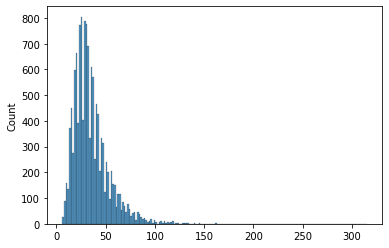

log value : 90.4092368060602


In [7]:
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train['문장']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+3*np.std(tokenizer_len)}')

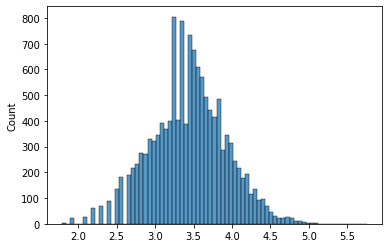

log value : 4.8974082584991345
original value : 133.94218592094492


In [8]:
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

In [9]:
base_model

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [10]:
class SentenceTypeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels=None):
        texts = dataframe['문장'].values.tolist()

        self.texts = [tokenizer(text, padding='max_length', max_length=90, truncation=True, return_tensors='pt') for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        if self.labels is not None:
            type_tmp = self.labels['type'][idx]
            polarity_tmp = self.labels['polarity'][idx]
            tense_tmp = self.labels['tense'][idx]
            certainty_tmp = self.labels['certainty'][idx]
            return text, torch.Tensor(type_tmp), torch.Tensor(polarity_tmp), torch.Tensor(tense_tmp), torch.Tensor(certainty_tmp)
        else:
            return text, torch.Tensor([-1,-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1])

In [11]:
class SentenceClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.klue = base_model # from transformers package

        self.fc1 = nn.Linear(768, 16)#large input1024, output1024
        self.relu = nn.ReLU()
        self.type_clf = nn.Linear(16,4)
        self.polarity_clf = nn.Linear(16,3)
        self.tense_clf = nn.Linear(16,3)
        self.certainty_clf = nn.Linear(16,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # input_ids : token's id / attention_mask : make a model to focus on which token
        klue_out = self.klue(input_ids= input_ids, attention_mask = attention_mask)[0][:,0]

        x = self.fc1(klue_out)
        x = self.relu(x)

        type_output = self.type_clf(x)
        type_output = self.softmax(type_output)
        polarity_output = self.polarity_clf(x)
        polarity_output = self.softmax(polarity_output)
        tense_output = self.tense_clf(x)
        tense_output = self.softmax(tense_output)
        certainty_output = self.certainty_clf(x)
        certainty_output = self.softmax(certainty_output)

        return type_output, polarity_output, tense_output, certainty_output

In [12]:
def sentence_train(model, train_dataloader, val_dataloader, learning_rate, epochs, model_nm):
    best_val_loss = 99999999999999 # setting max (act as infinity)
    early_stopping_threshold_count = 0

    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)

    for epoch in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        model.train() # sets into the training mode
        
        for train_input, type_label, polarity_label, tense_label, certainty_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)

            optimizer.zero_grad()
            
            type_output, polarity_output, tense_output, certainty_output = model(input_ids, attention_mask) # from the forward function
            
            loss = 0.25*criterion['type'](type_output, type_label.float()) + \
                   0.25*criterion['polarity'](polarity_output, polarity_label.float()) + \
                   0.25*criterion['tense'](tense_output, tense_label.float()) + \
                   0.25*criterion['certainty'](certainty_output, certainty_label.float())
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()


        with torch.no_grad(): # since we should not change gradient for validation 
            total_acc_val = 0
            total_loss_val = 0
            
            model.eval() # deactivate training
            
            # same process as the above
            for val_input, vtype_label, vpolarity_label, vtense_label, vcertainty_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                vtype_label = vtype_label.to(device)
                vpolarity_label = vpolarity_label.to(device)
                vtense_label = vtense_label.to(device)
                vcertainty_label = vcertainty_label.to(device)
                
                vtype_output, vpolarity_output, vtense_output, vcertainty_output = model(input_ids, attention_mask) # from the forward function

                loss = 0.25*criterion['type'](vtype_output, vtype_label.float()) + \
                        0.25*criterion['polarity'](vpolarity_output, vpolarity_label.float()) + \
                        0.25*criterion['tense'](vtense_output, vtense_label.float()) + \
                        0.25*criterion['certainty'](vcertainty_output, vcertainty_label.float())

                total_loss_val += loss.item()

            
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val # saving only the best one
                torch.save(model, f"/{model_nm}.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase
                
            if early_stopping_threshold_count >= 3: # ==> patience=1
                print("Early stopping")
                break

In [13]:
train_tmp = train[['문장', '유형', '극성', '시제', '확실성']]
train_tmp = pd.get_dummies(train_tmp, columns=['유형', '극성', '시제', '확실성'])#벡터화
train_tmp


,문장,유형_대화형,유형_사실형,유형_예측형,유형_추론형,극성_긍정,극성_미정,극성_부정,시제_과거,시제_미래,시제_현재,확실성_불확실,확실성_확실
0,용산구청 관계자는 ＂재정이 열악한 지자체로서는 1800억원을 마련할 수 없다＂며 서...,0,1,0,0,1,0,0,1,0,0,0,1
1,부산시는 이처럼 부산이 가파른 상승세를 보이는 이유에 대해 지난해부터 추진하고 있는...,0,1,0,0,1,0,0,1,0,0,0,1
2,"그러나 미숙아, 만성호흡기질환, 선천 심장병, 선천 면역결핍질환, 암환자 등의 고위...",0,1,0,0,1,0,0,0,0,1,0,1
3,탁구 종목에서 중국 대표팀 위상이 뛰어나기 때문이다.,0,0,0,1,1,0,0,0,0,1,0,1
4,이 논문에 따르면 ＇BT-11＇은 뇌의 신경전달물질인 아세틸콜린을 분해하는 효소의 ...,0,1,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,우리가 익히 아는 대로 임꺽정은 신출귀몰했다.,0,1,0,0,1,0,0,1,0,0,0,1
13228,김 상무보는 ＂실제 이용자 수와 인당 사용시간 등 주요 데이터가 매년 두 자릿수 상...,0,1,0,0,1,0,0,1,0,0,0,1
13229,＇디폴트 옵션＇의 필요성을 주장해온 쪽이 항상 사례로 들어온 것이 ＇401K＇로 불...,1,0,0,0,1,0,0,0,0,1,0,1
13230,1992년부터 선양시 조선족노인협회를 후원하기 시작해 1997년에는 1500㎡ 건물...,0,1,0,0,1,0,0,1,0,0,0,1


In [14]:
train_type = train_tmp.iloc[:,1:5].values.tolist()
train_polarity = train_tmp.iloc[:,5:8].values.tolist()
train_tense = train_tmp.iloc[:,8:11].values.tolist()
train_certainty = train_tmp.iloc[:,11:13].values.tolist()
train_labels = {
    'type': train_type,
    'polarity': train_polarity,
    'tense': train_tense,
    'certainty': train_certainty
}

val_tmp = val[['문장', '유형', '극성', '시제', '확실성']]
val_tmp = pd.get_dummies(val_tmp, columns=['유형', '극성', '시제', '확실성'])

val_type = val_tmp.iloc[:,1:5].values.tolist()
val_polarity = val_tmp.iloc[:,5:8].values.tolist()
val_tense = val_tmp.iloc[:,8:11].values.tolist()
val_certainty = val_tmp.iloc[:,11:13].values.tolist()
val_labels = {
    'type': val_type,
    'polarity': val_polarity,
    'tense': val_tense,
    'certainty': val_certainty
}

In [15]:
train_dataloader = DataLoader(SentenceTypeDataset(train_tmp, tokenizer, train_labels), batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0) # num_workers: how many subprocesses to use for data loading  
val_dataloader = DataLoader(SentenceTypeDataset(val_tmp, tokenizer, val_labels), batch_size=CFG['BATCH_SIZE'], num_workers=0)

In [16]:
model = SentenceClassifier(base_model)

In [17]:
sentence_train(model, train_dataloader, val_dataloader, CFG['LEARNING_RATE'], CFG['EPOCHS'], 'klue')

100%|██████████| 207/207 [00:08<00:00, 24.54it/s]


Epochs: 1 | Train Loss:  0.768 | Train Accuracy:  0.000 | Val Loss:  0.703 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.58it/s]


Epochs: 2 | Train Loss:  0.678 | Train Accuracy:  0.000 | Val Loss:  0.660 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.59it/s]


Epochs: 3 | Train Loss:  0.648 | Train Accuracy:  0.000 | Val Loss:  0.647 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.57it/s]


Epochs: 4 | Train Loss:  0.636 | Train Accuracy:  0.000 | Val Loss:  0.640 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.53it/s]


Epochs: 5 | Train Loss:  0.628 | Train Accuracy:  0.000 | Val Loss:  0.635 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.61it/s]


Epochs: 6 | Train Loss:  0.621 | Train Accuracy:  0.000 | Val Loss:  0.632 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.59it/s]


Epochs: 7 | Train Loss:  0.614 | Train Accuracy:  0.000 | Val Loss:  0.629 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.59it/s]


Epochs: 8 | Train Loss:  0.607 | Train Accuracy:  0.000 | Val Loss:  0.627 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.59it/s]


Epochs: 9 | Train Loss:  0.605 | Train Accuracy:  0.000 | Val Loss:  0.626 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.52it/s]


Epochs: 10 | Train Loss:  0.600 | Train Accuracy:  0.000 | Val Loss:  0.624 | Val Accuracy:  0.000
Saved model


100%|██████████| 207/207 [00:08<00:00, 24.58it/s]


Epochs: 11 | Train Loss:  0.598 | Train Accuracy:  0.000 | Val Loss:  0.625 | Val Accuracy:  0.000


100%|██████████| 207/207 [00:08<00:00, 24.58it/s]


Epochs: 12 | Train Loss:  0.596 | Train Accuracy:  0.000 | Val Loss:  0.627 | Val Accuracy:  0.000


100%|██████████| 207/207 [00:08<00:00, 24.59it/s]

Epochs: 13 | Train Loss:  0.594 | Train Accuracy:  0.000 | Val Loss:  0.630 | Val Accuracy:  0.000
Early stopping


In [18]:
def get_type_predictions(model, loader):

    device = torch.device("cuda")
    model = model.to(device)
    
    type_probs, polarity_probs, tense_probs, clarity_probs = [], [], [], []
    with torch.no_grad():
        model.eval()
        for data_input, _, _, _, _ in tqdm(loader):
            attention_mask = data_input['attention_mask'].to(device)
            input_ids = data_input['input_ids'].squeeze(1).to(device)


            type_output, polarity_output, tense_output, clarity_output = model(input_ids, attention_mask)
            type_probs.append(type_output)
            polarity_probs.append(polarity_output)
            tense_probs.append(tense_output)
            clarity_probs.append(clarity_output)
    
    return torch.cat(type_probs).cpu().detach().numpy(), \
            torch.cat(polarity_probs).cpu().detach().numpy(), \
            torch.cat(tense_probs).cpu().detach().numpy(), \
            torch.cat(clarity_probs).cpu().detach().numpy()

In [19]:
model = torch.load("/klue.pt")
test_dataloader = DataLoader(SentenceTypeDataset(test, tokenizer), batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [20]:
test_pred_type, test_pred_polarity, test_pred_tense, test_pred_certainty = get_type_predictions(model, test_dataloader)

100%|██████████| 444/444 [00:17<00:00, 24.95it/s]


In [21]:
test_type = ['대화형' if i==0 else '사실형' if i==1 else '예측형' if i==2 else '추론형' for i in [np.argmax(p) for p in test_pred_type]]
test_polarity = ['긍정' if i==0 else '미정' if i==1 else '부정' for i in [np.argmax(p) for p in test_pred_polarity]]
test_tense = ['과거' if i==0 else '미래' if i==1 else '현재' for i in [np.argmax(p) for p in test_pred_tense]]
test_certainty = ['불확실' if i==0 else '확실' for i in [np.argmax(p) for p in test_pred_certainty]]

In [24]:
label_sum = []
for i in range(len(test_type)):
    label_sum.append(f'{test_type[i]}-{test_polarity[i]}-{test_tense[i]}-{test_certainty[i]}')

submission['label'] = label_sum
submission.to_csv('/klue_robert_small_16.csv', index=False)

In [25]:
submission

,ID,label
0,TEST_0000,사실형-긍정-현재-확실
1,TEST_0001,사실형-긍정-현재-확실
2,TEST_0002,사실형-긍정-과거-확실
3,TEST_0003,사실형-긍정-과거-확실
4,TEST_0004,사실형-긍정-과거-확실
...,...,...
7085,TEST_7085,사실형-긍정-현재-확실
7086,TEST_7086,추론형-긍정-현재-확실
7087,TEST_7087,사실형-긍정-미래-확실
7088,TEST_7088,추론형-긍정-과거-확실
